In [6]:
import pandas as pd
import jieba as jb
from sklearn.externals import joblib
import numpy as np
import sys
# sys.setdefaultencoding("utf-8")

In [7]:
# qa_corpus = pd.read_csv('./qa_corpus.csv')
qa_corpus = pd.read_csv('./raw_chat_corpus/qingyun-11w/12万对话语料青云库.csv',sep='\t',engine='python',encoding="utf8")

In [8]:
qa_corpus.head()

,question,answer
0,南京在哪里,在这里了
1,咋死???红烧还是爆炒,"哦了哦了哦了,咱聊点别的吧"
2,你个小骚货，哥哥的巴操你爽不爽？,不要这样说嘛！很不文明哦
3,额麻麻怎么会有那玩意儿,无法理解您的话，获取帮助请发送 help
4,"孩纸,新年快乐",{r+}同乐同乐，大家一起乐~


In [9]:
len(qa_corpus)

117528

In [10]:
qa_corpus['question']

0                    南京在哪里
1              咋死???红烧还是爆炒
2         你个小骚货，哥哥的巴操你爽不爽？
3              额麻麻怎么会有那玩意儿
4                  孩纸,新年快乐
5                    拿尿冲一冲
6                   那重点是什么
7         在上一条我回复你,你怎么不回复我
8                    章子怡新宠
9                      求勾引
10                    说不粗来
11                    喜欢毛线
12         祝胡子润生日快乐成年happy
13                  刚才还说女生
14                      起来
15                  这年头都搞基
16                  唐杰不爱我了
17                那我请你吃kfc
18                    比尔盖茨
19              你个小黄毛,怎么说话
20              是我的错,没给你吃药
21                   回家见基友
22             你是我唯一朋友,可悲吗
23                  就是,,走你
24                 告诉她晚上加油
25                  看来你很爱钱
26           仔要跑去主人的梦里找主人了
27                洗干净,上桌等我
28                 无论大小都实成
29                   给我讲笑话
                ...       
117498          夏言轻最爱的士官大人
117499            你比移动智能多了
117500         solo?我让你一只手
117501                背个古诗
117502                这是鸟语
117503                 你生日
1

+ 对quest和answer做预处理，求词向量和句向量

In [11]:
import cut_sentence as cs
import hanlp
from tqdm import tqdm

tokenizer = hanlp.load('CTB6_CONVSEG')

def cut_sentence(sentence):
    cleaned_data = ''.join(re.findall(r'[\u4e00-\u9fa5]', sentence))
    return tokenizer(cleaned_data)

# cut_sentence('你丫再滚个我看看')

Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LookupTableImportV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MutexV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/

In [14]:
import re
all_sentence = []
all_questions = []
for idx in tqdm(range(len(qa_corpus))):
    q = qa_corpus['question'][idx]
#     q = ''.join(re.findall(r'[\u4e00-\u9fa5]', q))
    if isinstance(q,str):
        question = cs.segment(q,'arr')
        all_sentence.append(question)
        all_questions.append(question)
    a = qa_corpus['answer'][idx]
#     a = ''.join(re.findall(r'[\u4e00-\u9fa5]', a))
    if isinstance(a,str):
        answer = cs.segment(a,'arr')
        all_sentence.append(answer)

100%|████████████████████████████████████████████████████████████████████████| 117528/117528 [00:39<00:00, 2944.86it/s]


In [15]:
# 用fastText求所有的词向量
from gensim.models import FastText

model = FastText(all_sentence,size=8, window=3, min_count=1, iter=10,min_n = 3 , max_n = 6,word_ngrams = 0)

In [28]:
model.save("fasttext.model")

In [16]:
# 做句向量
X_sentences= []
new_sentences = []
for idx in range(len(all_questions)):
    sentence = all_questions[idx]
    if len(sentence)>0:
        vec = sum([model.wv[word] for word in sentence])/len(sentence)
        X_sentences.append(vec)
        new_sentences.append(sentence)

## 意图识别

#### 意图识别的目标是将问题分类
+ 先对语料库中的问题进行聚类

In [ ]:
# K-means的K能否用随机行走的方式来得到？
# 随机从一个点出发，寻找离这个点最近距离的点，然后移动到最近点，接着从这个点继续移动到下一个最近点，这条路径记为L；
# 寻找一个合适的K，使得K个团的L总和最小，并且每个K团之间的距离最大（尽可能分开）

In [17]:
# 使用K-mean聚类
from sklearn.cluster import KMeans

n_clusters = 5
kmean = KMeans(n_clusters=n_clusters)
kmean.fit(X_sentences)
print("kmean: k={}, cost={}".format(n_clusters, int(kmean.score(X_sentences))))

kmean: k=5, cost=-674843


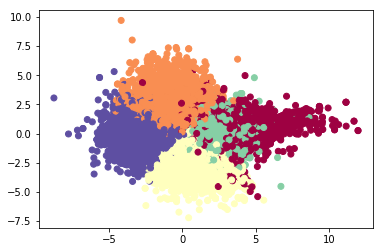

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

labels = kmean.labels_
centers = kmean.cluster_centers_
X_plot = np.array(X_sentences)
pca = PCA(n_components=2)   #降到2维
pca.fit(X_plot)                  #训练
newX=pca.fit_transform(X_plot)   #降维后的数据

fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.gca()
ax.scatter(newX[:, 0], newX[:, 1], c=labels, cmap=plt.cm.Spectral)
plt.show()

In [20]:
# 测试一下，输入句子属于哪一类
input = '你好'
x_quest = cs.segment(input,'arr')
x_vec = sum([model.wv[word] for word in x_quest])/len(x_quest)

print('class: ',kmean.predict([x_vec]))


class:  [0]


In [21]:
joblib.dump(kmean , 'km.pkl')

['km.pkl']

## 语义相似度判断

In [22]:
kmean = joblib.load('km.pkl')
print(kmean.labels_)

[2 1 2 ... 2 2 3]


In [20]:
def get_class(model,sentence):
    return model.predict([vectorize(sentence)])

In [22]:
from sklearn.neighbors import KDTree

class DataSpace():
    def __init__(self,classes_data):
        '''
        构建KD树
        '''
        points = len(classes_data)
        leaf = points/2-1
        self.tree = KDTree(classes_data,leaf)
        
    def __vectorize__(self,sentence):
        x_quest = cs.segment(sentence,'arr')
        return [sum([model.wv[word] for word in x_quest])/len(x_quest)]
    
    def similarity(self,sentence,topk=10):
        '''
        从KD树中找到最相似的k个数据
        '''
        v = self.__vectorize__(sentence)
        dist, ind = self.tree.query(v,k=topk)
        return (dist,ind)
    
    def save(self,filename):
        pass

In [23]:
data0 = DataSpace(np.array(X_sentences)[kmean.labels_==0])
sentence1 = np.array(new_sentences)[kmean.labels_==0]
data1 = DataSpace(np.array(X_sentences)[kmean.labels_==1])
sentence2 = np.array(new_sentences)[kmean.labels_==1]
data2 = DataSpace(np.array(X_sentences)[kmean.labels_==2])
sentence3 = np.array(new_sentences)[kmean.labels_==2]
data3 = DataSpace(np.array(X_sentences)[kmean.labels_==3])
sentence4 = np.array(new_sentences)[kmean.labels_==3]
data4 = DataSpace(np.array(X_sentences)[kmean.labels_==4])
sentence5 = np.array(new_sentences)[kmean.labels_==4]

In [24]:
_,ind = data2.similarity('你好')
sentence3[ind]

array([[list(['索', '小粒', '我', '的', '麻麻', '呀']), list(['是', '呀', '谢谢']),
        list(['真', '听话']),
        list(['嘿嘿', '必须', '的', '我', '这么', '可爱', '的', '~']),
        list(['就是', '主人', '你好', '聪明', '啊', '么', '么']),
        list(['比', '你', '高', '啦']), list(['你妹', '呀', '的']),
        list(['那', '是因为', '主人', '你', '更', '可爱', '呀']),
        list(['哈哈', '你妹']), list(['真', '他妈的', '贱'])]], dtype=object)

## 布尔搜索

In [25]:
import json

#建立词汇-文档表
class BoolSearch():
    def __init__(self,docs=None):
        if docs==None: return
        self.words={}
        #二进制位数
        self.bits = len(docs)
        self.keys = set()
        for indx in tqdm(range(self.bits)):
            for word in docs[indx]: self.keys.add(word)
                    
        for word in tqdm(self.keys):
            for indx in range(self.bits):
                if word not in self.words: self.words[word]=0
                self.words[word] <<= 1
                if word in docs[indx]:
                    self.words[word] |= 1
#         print(self.words)
        self.mask = self.__all__(self.bits)

    def __itr_dict__(self,doc):
        # 1.先遍历词典,判断词典中的词是否在新文档中
        for word in self.words.keys():
        # 2.如果在文档中
            self.words[word] <<= 1
            if word in doc:
        # 3.就向左移位并加一
                self.words[word] |= 1
        # 4.否则只向左移位
        # 5.然后从文档中移除这个词
                while word in doc: doc.remove(word)
                
    def __itr_doc__(self,doc):
        # 6.接着遍历文档中剩下的词,重复步骤3
        for word in doc:
            self.words[word] = 0
            self.words[word] <<= 1
            self.words[word] |= 1
                    
    def __all__(self,n):
        num = 1
        for i in range(n-1):
            num <<=1
            num |= 1
        return num
    
    def search(self,input):
        result = self.mask
#         print(self.bits,result)
        for word in input:
            if not self.words.__contains__(word): continue
            result &= self.words[word]
        return result
    
    def show(self):
        print(self.words)
        
    def get_indexes(self,input):
        result = self.search(input)
        indexes = []
        for indx in range(self.bits):
            if result & 1: indexes.append(self.bits-indx -1)
            result >>=1
        return indexes
    
    def save(self,filepath):
        with open(filepath, 'w') as fw:
            json.dump({'bits':self.bits,'words':self.words},fw)
        
    def load(self,filepath):
        with open(filepath,'r') as f:
            s = json.load(f)
            self.bits = s['bits']
            self.words = s['words']
            self.mask = self.__all__(self.bits)
            

In [26]:
bool_search = BoolSearch(all_questions)

100%|██████████████████████████████████████████████████████████████████████████| 39362/39362 [1:42:38<00:00,  6.39it/s]


In [27]:
bool_search.save('search_answer.jsn')